In [1]:
from google.colab import drive ;
drive.mount('/content/drive') ;

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os ;
import cv2 ;
import numpy as np ;
from os import listdir ;
import matplotlib.image as mpimg ;
import matplotlib.pyplot as plt ;
from skimage.color import rgb2lab, lab2rgb ;

In [3]:
sourceDirectory = "/content/drive/MyDrive/Celeb-A/img_align_celeba/images/" ;
num_images = 8000 ;
images = [] ;

In [4]:
# I tried to make a subdirectory extractor
for image in os.listdir(sourceDirectory):
    if(image.endswith(".jpg")):
        data = mpimg.imread(sourceDirectory + '/' + image) ;
        data = cv2.resize(data, (128,128)) ;
        images.append(data) ;
        if(len(images) >= num_images):
          break ;

In [5]:
images = np.array(images, dtype='float32')/255 ;
images.shape

(8000, 128, 128, 3)

In [6]:
from sklearn.model_selection import train_test_split ;
xtrain, xtest = train_test_split(images, test_size=1000) ;
del images ;

In [7]:
print('Training Images: ', xtrain.shape) ;
print('Testing Images: ', xtest.shape) ;

Training Images:  (7000, 128, 128, 3)
Testing Images:  (1000, 128, 128, 3)


In [8]:
np.save('xtest.npy', xtest) ;
del xtest ;

In [9]:
import tensorflow as tf ;
from tensorflow.keras import layers, models ;
from tensorflow.keras.utils import plot_model ;

In [10]:
np.random.seed(123) ;
tf.random.set_seed(123) ;
device = tf.test.gpu_device_name() ;
device

'/device:GPU:0'

In [11]:
# Down sampler CNN network
def downCNN(name, filters, kernel_size, batchNormalization = True):
    downsampler = models.Sequential() ;
    downsampler._name = name ;
    downsampler.add(layers.Conv2D(filters, kernel_size, padding = 'same', strides = 2)) ;
    if batchNormalization: downsampler.add(layers.BatchNormalization()) ;
    downsampler.add(layers.LeakyReLU()) ;
    return downsampler ;

In [12]:
# Up sampler CNN network
def upCNN(name, filters, kernel_size, normalize=True, dropOut = True):
    upsampler = models.Sequential() ;
    upsampler._name = name ;
    upsampler.add(layers.Conv2DTranspose(filters, kernel_size, padding = 'same', strides = 2)) ;
    if normalize: upsampler.add(layers.BatchNormalization()) ;
    if dropOut: upsampler.add(layers.Dropout(0.2)) ;
    upsampler.add(layers.LeakyReLU()) ;
    return upsampler ;

In [13]:
downsampler = downCNN("Down-sampler", 128, (3,3), True) ;
upsampler = upCNN("Up-sampler", 128, (3,3), True, True) ;
downsampler.build(input_shape=(None,128,128,3)) ;
upsampler.build(input_shape=(None,64,64,3)) ;
plot_model(downsampler, to_file='downsampler128filters.png', show_shapes=True) ;
plot_model(upsampler, to_file="upsampler128filters.png", show_shapes=True) ;
del downsampler ;
del upsampler ;

In [14]:
def AutoEncoder():
    # Input grayscale images of dimensions 128*128
    image = layers.Input(shape = [128,128,3]) ;

    # Feed it to an encoder network for downsampling to a latent vector
    d1 = downCNN("Downsampler_1", 128,(3,3),True)(image) ;
    d2 = downCNN("Downsampler_2", 128,(3,3),True)(d1) ;
    d3 = downCNN("Downsampler_3", 256,(3,3),True)(d2) ;
    d4 = downCNN("Downsampler_4", 512,(3,3),True)(d3) ;
    d5 = downCNN("Downsampler_5", 512,(3,3),False)(d4) ;

    # Decode the latent space bottleneck to upscale into large image matrix
    u1 = upCNN("Upsampler_1", 512,(3,3),True,False)(d5) ;
    u2 = upCNN("Upsampler_2", 256,(3,3),True,False)(u1) ;
    u3 = upCNN("Upsampler_3", 128,(3,3),True,False)(u2) ;
    u4 = upCNN("Upsampler_4", 128,(3,3),True,False)(u3) ;
    u5 = upCNN("Upsampler_5", 3,(3,3),False,False)(u4) ;

    # Generate colored images with final convolution
    output = layers.Conv2D(3, (2,2), strides = 1, activation='sigmoid', padding = 'same')(u5) ;
    return models.Model(inputs=image, outputs=output) ;

In [15]:
denoiser = AutoEncoder() ;
plot_model(denoiser, to_file='denoiserUsingAutoEncoder128*128.png', show_shapes=True) ;
print(denoiser.summary()) ;

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 Downsampler_1 (Sequential)  (None, 64, 64, 128)       4096      
                                                                 
 Downsampler_2 (Sequential)  (None, 32, 32, 128)       148096    
                                                                 
 Downsampler_3 (Sequential)  (None, 16, 16, 256)       296192    
                                                                 
 Downsampler_4 (Sequential)  (None, 8, 8, 512)         1182208   
                                                                 
 Downsampler_5 (Sequential)  (None, 4, 4, 512)         2359808   
                                                                 
 Upsampler_1 (Sequential)    (None, 8, 8, 512)         236185

Dataset Analysis & Preprocessing

In [16]:
def showImage(data, index, label=None):
  plt.figure(figsize=(0.5, 0.5)) ;
  plt.imshow(data[index]) ;
  if label != None:
    plt.xlabel('Human') ;

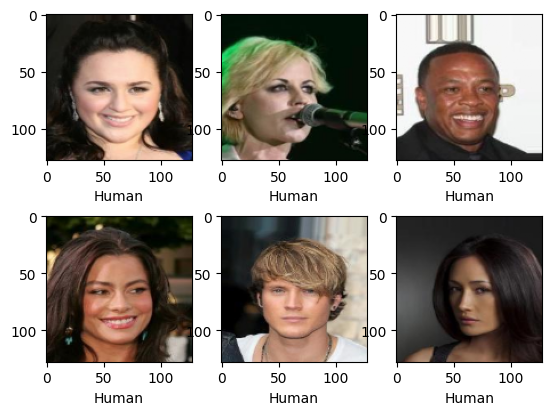

In [17]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrain[i]) ;
    axes[int(i/3)][int(i%3)].set_xlabel('Human') ;
plt.show() ;

In [18]:
# Adding noise on the images
noise_factor = 0.25 ;
xtrainN = np.zeros((xtrain.shape[0],128,128,3)).astype(np.float32) ;
xtrainN = xtrain + noise_factor * np.random.normal(loc = 0.0 ,scale = 1.0, size = xtrain.shape) ;
xtrainN = np.clip(xtrainN, 0.0, 1.0) ;

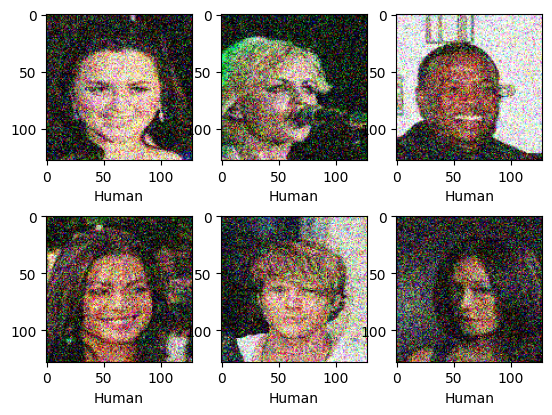

In [19]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrainN[i]) ;
    axes[int(i/3)][int(i%3)].set_xlabel('Human') ;
plt.show() ;

Model Training & Evaluation

In [20]:
denoiser.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['accuracy']) ;
denoiser

In [21]:
# !!! WARNING: This optimizes CPU performance - DON'T USE THIS WHEN GPU IS ENABLED !!! (Learnt the hard way!)
# tf.config.run_functions_eagerly(True) ; #  IT ENABLES CONVOLUTION LAYER TO FUNCTION EARLY CAUSING ISSUES IN TENSORS IF GPU IS USED
# tf.data.experimental.enable_debug_mode() ; # IT DISABLES PARALLELISM AND FORCES SEQUENTIAL OPERATION

In [22]:
history = denoiser.fit(xtrainN, xtrain, epochs = 200, batch_size = 50, validation_split=0.05, shuffle=True, verbose = True) ;

Epoch 1/200
133/133 [==============================] - 35s 139ms/step - loss: 0.1018 - accuracy: 0.6550 - val_loss: 0.1616 - val_accuracy: 0.7781
Epoch 2/200
133/133 [==============================] - 18s 137ms/step - loss: 0.0672 - accuracy: 0.7915 - val_loss: 0.1650 - val_accuracy: 0.7254
Epoch 3/200
133/133 [==============================] - 19s 140ms/step - loss: 0.0579 - accuracy: 0.8063 - val_loss: 0.1095 - val_accuracy: 0.8291
Epoch 4/200
133/133 [==============================] - 19s 146ms/step - loss: 0.0558 - accuracy: 0.8061 - val_loss: 0.0578 - val_accuracy: 0.7985
Epoch 5/200
133/133 [==============================] - 20s 151ms/step - loss: 0.0543 - accuracy: 0.8064 - val_loss: 0.0524 - val_accuracy: 0.8236
Epoch 6/200
133/133 [==============================] - 20s 148ms/step - loss: 0.0527 - accuracy: 0.8094 - val_loss: 0.0834 - val_accuracy: 0.8067
Epoch 7/200
133/133 [==============================] - 19s 144ms/step - loss: 0.0500 - accuracy: 0.8115 - val_loss: 0.0563 -

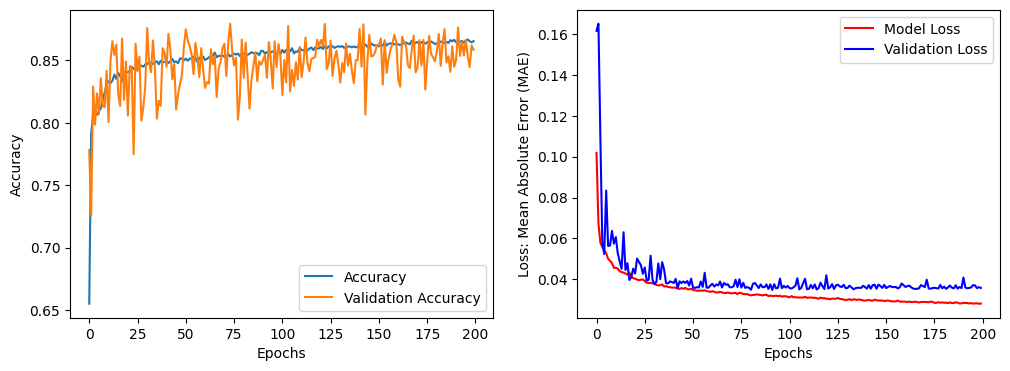

In [23]:
figure, axes = plt.subplots(1,2, figsize=(12,4)) ;
axes[0].plot(history.history['accuracy'], label='Accuracy') ;
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy') ;
axes[0].set_xlabel('Epochs') ;
axes[0].set_ylabel('Accuracy') ;
axes[0].legend() ;
axes[1].plot(history.history['loss'], color='red', label='Model Loss') ;
axes[1].plot(history.history['val_loss'], color='blue', label='Validation Loss') ;
axes[1].set_xlabel('Epochs') ;
axes[1].set_ylabel('Loss: Mean Absolute Error (MAE)') ;
axes[1].legend() ;
plt.show() ;

In [24]:
!pip install pyyaml h5py
denoiser.save('autoEncoderCNN_denoiser_celebs.h5') ;
denoiser.save('autoEncoderCNN_denoiser_celebs.keras') ;

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
del xtrain ;
xtest = np.load('xtest.npy') ;

In [26]:
xtestN = np.zeros((xtest.shape[0],128,128,3)).astype(np.float32) ;
xtestN = xtest + noise_factor * np.random.normal(loc = 0.0 ,scale = 1.0, size = xtestN.shape) ;
xtestN = np.clip(xtestN, 0.0, 1.0) ;

In [27]:
denoiser.evaluate(xtestN, xtest) ;

32/32 [==============================] - 3s 48ms/step - loss: 0.0361 - accuracy: 0.8523


Model Prediction & Output Overview

In [ ]:
showImage(xtest, 0) ;

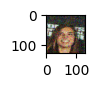

In [29]:
showImage(xtestN, 0) ;

In [30]:
coloredOutput = denoiser.predict(xtestN[0].reshape(1,128,128,3)) ;

1/1 [==============================] - 1s 543ms/step


In [ ]:
coloredOutput = coloredOutput.astype(np.float32) ;
showImage(coloredOutput, 0) ;

1/1 [==============================] - 0s 31ms/step


<ipython-input-32-072be304bbbf>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;


1/1 [==============================] - 0s 28ms/step


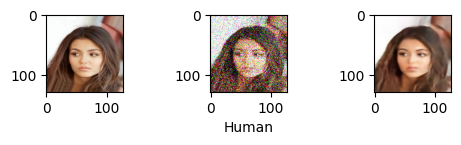

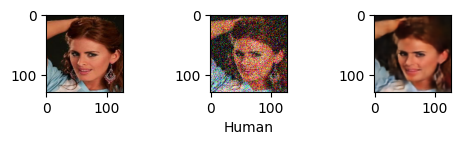

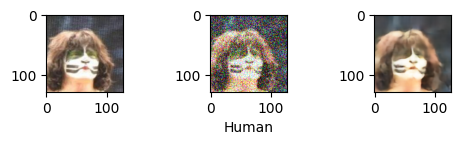

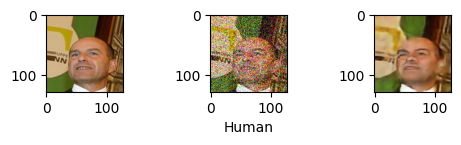

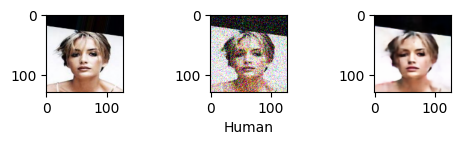

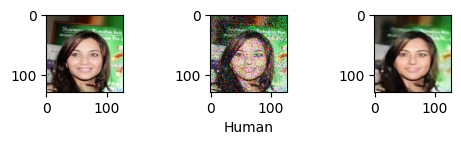

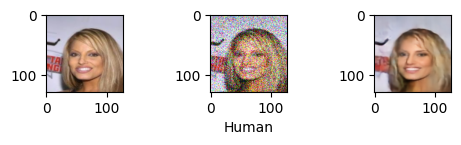

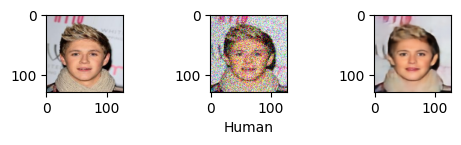

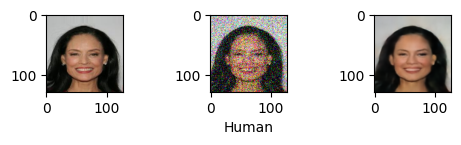

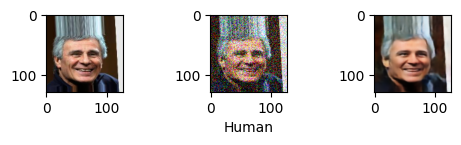

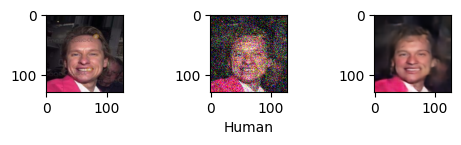

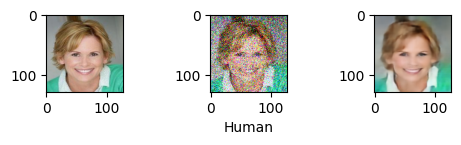

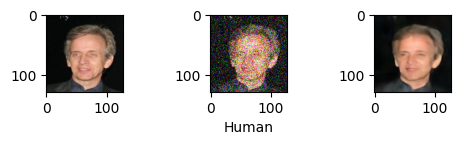

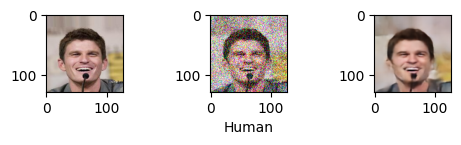

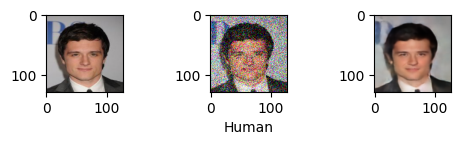

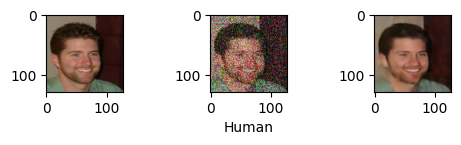

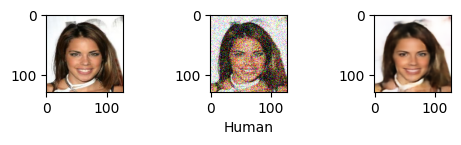

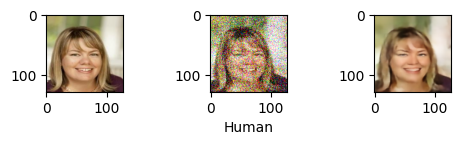

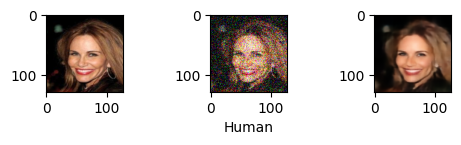

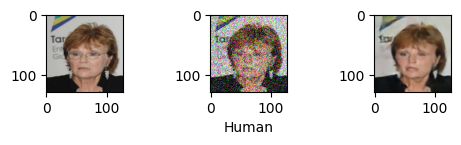

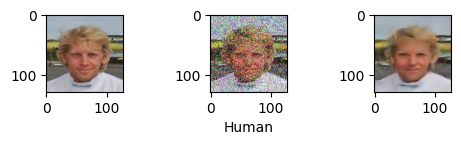

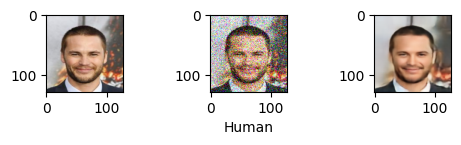

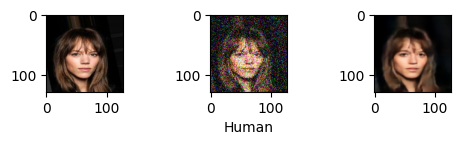

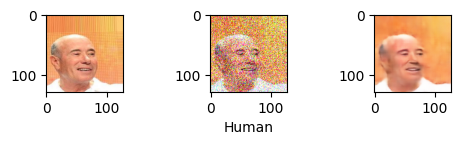

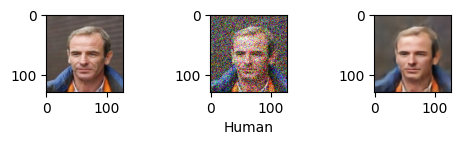

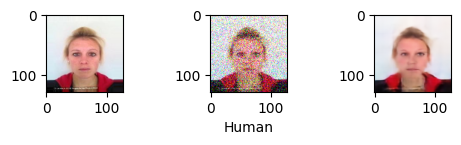

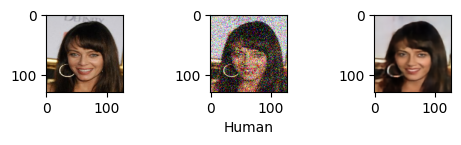

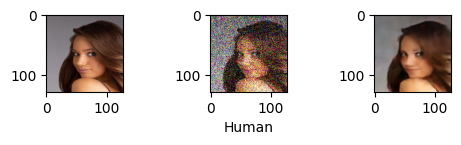

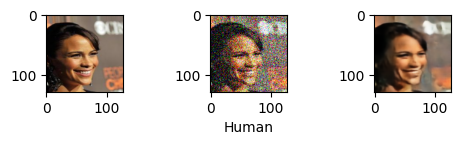

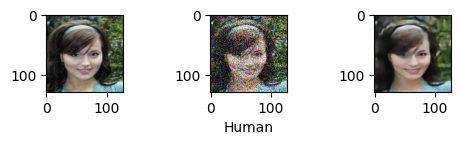

In [32]:
randomIndex = np.random.randint(low=0, high=500, size=30) ;
for i in randomIndex:
  output = denoiser.predict(xtestN[i].reshape(1,128,128,3)) ;
  output = np.clip(output, 0.0, 1.0).astype(np.float32) ;
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;
  axes[0].imshow(xtest[i]) ;
  axes[1].imshow(xtestN[i], ) ;
  axes[1].set_xlabel('Human') ;
  axes[2].imshow(output[0]) ;
plt.show() ;